In [46]:
# only run this cell if you are in collab
!pip install ohmeow-blurr -q
!pip install datasets -q
!pip install bert-score -q
import datasets
import pandas as pd

#!pip install fastai==2.1.8
#!pip install fastcore==1.3.1
from fastai import *
from fastcore import *
from fastai.text.all import *

from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

# Data Preparation
We're going to use to use the datasets library from huggingface to grab your raw data. This package gives you access to all kinds of NLP related datasets, explanations of each, and various task specific metrics to use in evaluating your model. The best part being everything comes down to you in JSON! This makes it a breeze to get up and running quickly!

We'll just use a subset of the training set to build both our training and validation DataLoaders

In [6]:
import os
from google.colab import files

uploaded = files.upload()

import io

  
df = pd.read_csv(io.BytesIO(uploaded['15min_tekstai.csv']), sep='\t')
#df = pd.read_csv('/content/15min_tekstai.csv', sep='\t')

df.head()

Saving 15min_tekstai.csv to 15min_tekstai.csv


,Unnamed: 0,title,text,summary,author,Unnamed: 0.1
0,0,"M.Zingeris: nepasinaudojus žydų bendruomenės potencialu, valstybę atkurti būtų buvę daug sunkiau","Visų pirma verta prisiminti tuos, kurie prie valstybės atkūrimo, o vėliau ir išsaugojimo, prisidėjo tiesiogiai. Tai 1918–1920 metais Nepriklausomybės kovose dalyvavę Lietuvos žydai. Manoma, kad jų buvo apie 3 tūkstančiai, apie 500 — savanoriai. Pasak 15min pašnekovo, šimtai jų, kai kurie jau po mirties, pagerbti ordinais ir medaliais. Kelios dešimtys Lietuvos patriotų žydų apdovanoti Vyčio kryžiaus ordinais.„Prisiminkime Libą Mednikienę iš Širvintų, apdovanotą, kaip tada sakydavo, Vyties (dabar — Vyčio) kryžiaus ordinu už pagalbą Lietuvos kariuomenei ir žvalgybai“, — kalbėjo M.Zingeris.15m...","Valstybę kūrė ne tik etniniai lietuviai, bet ir amžių amžius čia gyvenę žydai litvakai. Anot rašytojo, publicisto Marko Zingerio, to nežinant prieš akis iškyla vienpusis, primityvus, ryškias spalvas praradęs ano meto paveikslas. Vasario 16-oji – puiki proga nuspalvinti tą gerokai išblukusį supratimą.",Aleknavičė Karolina,0.0
1,1,"G.Mažeikis apie tai, kodėl tikime sąmokslo teorijomis ir kaip su jomis kovoti: vos tik uždrausi, iškart išvešės","Sąmokslo teorijos, paaiškino 15min pašnekovas, tai įsivaizdavimas, kad už mūsų nugarų stovi „lėlininkai“, kurie gyvenimus reguliuoja nematomais įrankiais, slaptais susitarimais.„Šios teorijos remiasi priežastiniu mąstymu, įsitikinimu, kad bet kuris įvykis turi konkrečią priežastį ir niekas nekyla spontaniškai. Iš esmės tai neigia laisvės teoriją ir kūrybingumą. Sąmokslo teorijos labai patinka tiems, kurie mėgsta skaičiuoti priežastis“, — svarstė jis ir pridūrė dar vieną įdomų pastebėjimą: sąmokslo teorijos neigia stebuklus, nes stebuklas priklauso spontaniškumo, vadinasi, laisvės sferai. T...","Nors gali atrodyti, kad į baimių pilną sąmokslo teorijų pasaulį pakliūva tik neišsilavinę žmonės, taip nėra. Pasak Vytauto Didžiojo universiteto profesoriaus, Filosofijos ir socialinės kritikos katedros vedėjo Gintauto Mažeikio, tai priklauso nuo to, kiek konkretus asmuo yra linkęs į determinizmą, todėl bet kuris, nepriklausomai nuo išsilavinimo ar politinių pažiūrų, gali įkliūti. O įveikti tai galima ugdant kūrybiškumą ir spontaniškumą – savybes, prieš kurias neatsilaiko jokie sąmokslai.",Aleknavičė Karolina,1.0
2,2,"Istorikas A.Jakubčionis: Lietuva vis tiek būtų tapusi laisva, Sovietų Sąjunga griuvo iš vidaus","Prisimindamas Sausio 13-osios aplinkybes, 15min kalbintas istorikas pabrėžė, kad 1990-ieji buvo laikas, kai laisvės siekiu gyvuojančią Lietuvą Sovietų Sąjunga bandė paveikti įvairiais būdais. Visų pirma, anot jo, visuomenę bandyta įbauginti. Vos paskelbus nepriklausomybę, pasipylė reikalavimai visus aktus nutraukti ir planų atsisakyti, grasinant ekonomine blokada. Griebtasi ir kitų priemonių — pranešta apie karinę prievolę. Galiausiai prasidėjo ekonominė blokada.Pasak A.Jakubčionio, ji išryškino kad Lietuva dar pernelyg integruota į Sovietų Sąjungą ir kad abi yra priklausomos nuo viena kit...","O kas, jeigu ne Sausio 13-oji? Istorikas, Vilniaus universiteto (VU) docentas dr. Algirdas Jakubčionis pastebi, kad net jeigu lemtingą naktį gatvės taip ir būtų likusios tuščios – Lietuva vis tiek būtų tapusi laisva, nes iš vidaus supuvusi Sovietų Sąjunga neturėjo šansų išlikti. Vis dėlto, ne nesuvaldoma istorijos tėkmė, o sąmoningas tautos apsisprendimas atvedė į Sausio 13-ąją. Nors laisvę bandyta slopinti ne tik brutalia jėga, bet ir ekonominėmis priemonėmis bei grasinimais, visuomenė aiškiai parodė — norime gyventi savarankiškoje valstybėje.",Aleknavičė Karolina,2.0
3,3,Dziudo sportininkės mama ir dukra – prieš socialinę atskirtį: ne visi gali sumokėti už vaiko būrelį,"Pasak 15min kalbintos L.Dudėnienės, idėja kovai su socialine atskirtimi pasitelkti dziudo kovos meną subrendo natūraliai.„Mūsų klubą, — prisiminė ji, — dažnai rinkdavosi tie sportininkai ar mažųjų sportininkų tėveliai, kurie neturėjo galimybių mokėti arba jiems kitų klubų siūlomi dziudo tre

In [47]:
raw_data = datasets.load_dataset('csv', data_files='/content/15min_tekstai.csv', delimiter = '\t', split='train[:80%]')


Using custom data configuration default-369287341699e138
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-369287341699e138/0.0.0/965b6429be0fc05f975b608ce64e1fa941cc8fb4f30629b523d2390f3c0e1a93)


In [48]:
df = pd.DataFrame(raw_data)
df.head()

,Unnamed: 0,title,text,summary,author,Unnamed: 0.1
0,0,"M.Zingeris: nepasinaudojus žydų bendruomenės potencialu, valstybę atkurti būtų buvę daug sunkiau","Visų pirma verta prisiminti tuos, kurie prie valstybės atkūrimo, o vėliau ir išsaugojimo, prisidėjo tiesiogiai. Tai 1918–1920 metais Nepriklausomybės kovose dalyvavę Lietuvos žydai. Manoma, kad jų buvo apie 3 tūkstančiai, apie 500 — savanoriai. Pasak 15min pašnekovo, šimtai jų, kai kurie jau po mirties, pagerbti ordinais ir medaliais. Kelios dešimtys Lietuvos patriotų žydų apdovanoti Vyčio kryžiaus ordinais.„Prisiminkime Libą Mednikienę iš Širvintų, apdovanotą, kaip tada sakydavo, Vyties (dabar — Vyčio) kryžiaus ordinu už pagalbą Lietuvos kariuomenei ir žvalgybai“, — kalbėjo M.Zingeris.15m...","Valstybę kūrė ne tik etniniai lietuviai, bet ir amžių amžius čia gyvenę žydai litvakai. Anot rašytojo, publicisto Marko Zingerio, to nežinant prieš akis iškyla vienpusis, primityvus, ryškias spalvas praradęs ano meto paveikslas. Vasario 16-oji – puiki proga nuspalvinti tą gerokai išblukusį supratimą.",Aleknavičė Karolina,0.0
1,1,"G.Mažeikis apie tai, kodėl tikime sąmokslo teorijomis ir kaip su jomis kovoti: vos tik uždrausi, iškart išvešės","Sąmokslo teorijos, paaiškino 15min pašnekovas, tai įsivaizdavimas, kad už mūsų nugarų stovi „lėlininkai“, kurie gyvenimus reguliuoja nematomais įrankiais, slaptais susitarimais.„Šios teorijos remiasi priežastiniu mąstymu, įsitikinimu, kad bet kuris įvykis turi konkrečią priežastį ir niekas nekyla spontaniškai. Iš esmės tai neigia laisvės teoriją ir kūrybingumą. Sąmokslo teorijos labai patinka tiems, kurie mėgsta skaičiuoti priežastis“, — svarstė jis ir pridūrė dar vieną įdomų pastebėjimą: sąmokslo teorijos neigia stebuklus, nes stebuklas priklauso spontaniškumo, vadinasi, laisvės sferai. T...","Nors gali atrodyti, kad į baimių pilną sąmokslo teorijų pasaulį pakliūva tik neišsilavinę žmonės, taip nėra. Pasak Vytauto Didžiojo universiteto profesoriaus, Filosofijos ir socialinės kritikos katedros vedėjo Gintauto Mažeikio, tai priklauso nuo to, kiek konkretus asmuo yra linkęs į determinizmą, todėl bet kuris, nepriklausomai nuo išsilavinimo ar politinių pažiūrų, gali įkliūti. O įveikti tai galima ugdant kūrybiškumą ir spontaniškumą – savybes, prieš kurias neatsilaiko jokie sąmokslai.",Aleknavičė Karolina,1.0
2,2,"Istorikas A.Jakubčionis: Lietuva vis tiek būtų tapusi laisva, Sovietų Sąjunga griuvo iš vidaus","Prisimindamas Sausio 13-osios aplinkybes, 15min kalbintas istorikas pabrėžė, kad 1990-ieji buvo laikas, kai laisvės siekiu gyvuojančią Lietuvą Sovietų Sąjunga bandė paveikti įvairiais būdais. Visų pirma, anot jo, visuomenę bandyta įbauginti. Vos paskelbus nepriklausomybę, pasipylė reikalavimai visus aktus nutraukti ir planų atsisakyti, grasinant ekonomine blokada. Griebtasi ir kitų priemonių — pranešta apie karinę prievolę. Galiausiai prasidėjo ekonominė blokada.Pasak A.Jakubčionio, ji išryškino kad Lietuva dar pernelyg integruota į Sovietų Sąjungą ir kad abi yra priklausomos nuo viena kit...","O kas, jeigu ne Sausio 13-oji? Istorikas, Vilniaus universiteto (VU) docentas dr. Algirdas Jakubčionis pastebi, kad net jeigu lemtingą naktį gatvės taip ir būtų likusios tuščios – Lietuva vis tiek būtų tapusi laisva, nes iš vidaus supuvusi Sovietų Sąjunga neturėjo šansų išlikti. Vis dėlto, ne nesuvaldoma istorijos tėkmė, o sąmoningas tautos apsisprendimas atvedė į Sausio 13-ąją. Nors laisvę bandyta slopinti ne tik brutalia jėga, bet ir ekonominėmis priemonėmis bei grasinimais, visuomenė aiškiai parodė — norime gyventi savarankiškoje valstybėje.",Aleknavičė Karolina,2.0
3,3,Dziudo sportininkės mama ir dukra – prieš socialinę atskirtį: ne visi gali sumokėti už vaiko būrelį,"Pasak 15min kalbintos L.Dudėnienės, idėja kovai su socialine atskirtimi pasitelkti dziudo kovos meną subrendo natūraliai.„Mūsų klubą, — prisiminė ji, — dažnai rinkdavosi tie sportininkai ar mažųjų sportininkų tėveliai, kurie neturėjo galimybių mokėti arba jiems kitų klubų siūlomi dziudo tre

In [49]:
df = df[[(len(x) > 30) for x in df.summary]]
len(df)

24945



We begin by getting our hugginface objects needed for this task (e.g., the architecture, tokenizer, config, and model). We'll use blurr's get_hf_objects helper method here.


In [50]:
#pretrained_model_name = "facebook/bart-large-xsum"
pretrained_model_name = "facebook/bart-large-cnn"

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)



Next we need to build out our DataBlock. Remember tha a DataBlock is a blueprint describing how to move your raw data into something modelable. That blueprint is executed when we pass it a data source, which in our case, will be the DataFrame we created above. We'll use a random subset to get things moving along a bit faster for the demo as well.

Notice that the blurr DataBlock as been dramatically simplified given the shift to on-the-fly batch-time tokenization. All we need is to define a single HF_Seq2SeqBeforeBatchTransform instance, optionally passing a list to any of the tokenization arguments to differentiate the values for the input and summary sequences. In addition to specifying a custom max length for the inputs, we can also do the same for the output sequences ... and with the latest release of blurr, we can even customize the text generation by passing in text_gen_kwargs.

We pass noop as a type transform for our targets because everything is already handled by the batch transform now.


In [51]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'encoder_no_repeat_ngram_size': 0,
 'eos_token_id': 2,
 'length_penalty': 2.0,
 'max_length': 142,
 'min_length': 56,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 4,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 1,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [52]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=512, max_tgt_length=128, text_gen_kwargs=text_gen_kwargs) # reiktu pabandyti pakeisti max_length = 512 ir max_tgt_length = 128

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader('summary'), splitter=RandomSplitter())



In [53]:
dls = dblock.dataloaders(df, bs=2)
len(dls.train.items), len(dls.valid.items)

(19956, 4989)

It's always a good idea to check out a batch of data and make sure the shapes look right.

In [54]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 512]), torch.Size([2, 229]))

Even better, we can take advantage of blurr's TypeDispatched version of show_batch to look at things a bit more intuitively. We pass in the dls via the dataloaders argument so we can access all tokenization/modeling configuration stored in our batch transform above.

In [55]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"Muzikos mokykla „Varpelis“ įsikūrusi Kauno centre, D.Poškos gatvėje. Dalyje pastato ilgą laiką veikė „Kraujo donorystės centro“ laboratorija. Vėliau patalpos buvo parduotos kitam savininkui, kuris ėmėsi remonto darbų ir kūrė planus įrengti jose svečių namus. Tačiau apie tai sužinoję, mokyklos mokinių tėveliai sukilo: kur matyta, kad švietimo įstaigos pastate veiktų viešbutis?„Mano sūnus lanko šią mokyklą. Joje ir taip trūksta vietos koncertinei veiklai. Tų patalpų būtų prireikę mokyklai, bet įsigijo kažkoks verslininkas. Ėmė daryti remontą. Be jokių sutikimų ir leidimų. Patalpos skirtingos, bet pastatas tai juk tas pats. Mokyklai panaudos pagrindais priklauso didžioji jo dalis. Tas verslininkas ruošiasi pakeisti savo dalyje paskirtį. O tai neatitinka žemės naudojimo visuomeninės paskirties teritorijos. Jame negali būti viešbučių, nes tokie pastatai gali būti tik komercinės paskirties objektų teritorijoje.Niekur Lietuvoje nėra taip, kad tame pačiame pastate veiktų ir mokykla, ir sveči�","Kauno berniukų chorinio dainavimo mokyklos „Varpelis“ mokinių tėvai sunerimę: dalyje švietimo įstaigos ruošiamasi įkurdinti svečių namus. „Viešbutis ugdymo įstaigoje, kur tai matyta?“ – piktinasi protestuojantys. Būsimų svečių namų savininkas Rimas Tunyla juos ramina, juk patalpos – atskirtos. Verslininkui nesuvokiama, kodėl Lietuvoje taip žlugdomas verslas. Teisybės jis žada ieškoti teismuose."
1,"Taigi, kuo geri ir kuo blogi naujieji „Huawei“ superflagmanai? Beje, superflagmanai – dėl to, kad šiek tiek išsiskiria iš „standartinių flagmanų“ P40 serijos. Panašiai, kaip ir, tarkime, „iPhone Pro“ ar „Samsung Ultra“ serijos aparatai. Panašūs į flagmanus, bet su tokiais privalumais į kuriuos negalima atkreipti dėmesio.Naujųjų telefonų „kūnai“ nuo įprastinės P40 serijos nutolo labai nedaug. Netgi įvertinus tai, kad esu didžiulis užlankstytų ekrano šonų kritikas, o P40 serijos aparatų užlenktos ne tik šoninės, bet ir viršutinė bei apatinė stiklo briaunos, privalau pripažinti, kad rankoje šie telefonai guli pasiutusiai gerai. Vargu, ar kokį malonesnį telefoną apskritai rinkoje rastumėte. Didžiulę to malonumo dalį sudaro už įprastą šiek tiek didesnis telefono svoris (226 g) ir storis (9 mm).Pastaba: įprastai šiuolaikiški flagmanai sveria maždaug nuo 180 iki 200 gramų. O 20 procentų svorio skirtumas – tai jau velniškai daug.Aišku, skamba keistai. Nuo kada storesnis ir sunkesnis telefonas yra privalumas? Ir net pats to paaiškinti dorai","Apie įmonės „Huawei“ telefonus kelis pastaruosius metus buvo galima atsiliepti tik iš geriausios pusės. Visa techninė šių aparatų pusė buvo nė kiek ne prastesnė, nei gana dažnai brangesnių konkurentų telefonų, o fotoaparatai... fotoaparatai buvo tiesiog nepralenkiami. Lygiai tą patį galima pasakyti ir apie pačius naujausius, karščiausius ir kiečiausius „Huawei P40 Pro+“ aparatus, kurie kai kuriais atžvilgiais iškyla visa galva aukščiau konkurentų. Ir net ne „kai kurių konkurentų“, o „visų konkurentų“."


# **Training**
We'll prepare our BART model for training by wrapping it in blurr's HF_BaseModelWrapper object and using the callback, HF_BaseModelCallback, as usual. A new HF_Seq2SeqMetricsCallback object allows us to specify Seq2Seq metrics we want to use, things like rouge and bertscore for tasks like summarization as well as metrics such as meteor, bleu, and sacrebleu for translations tasks. Using huggingface's metrics library is as easy as specifying a metrics configuration such as below.

Once we have everything in place, we'll freeze our model so that only the last layer group's parameters of trainable. See here for our discriminitative learning rates work in fastai.

**Note**: This has been tested with ALOT of other Seq2Seq models; see the docs for more information.

In [56]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'lt' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [57]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

Still experimenting with how to use fastai's learning rate finder for these kinds of models. If you all have any suggestions or interesting insights to share, please let me know. We're only going to train the frozen model for one epoch for this demo, but feel free to progressively unfreeze the model and train the other layers to see if you can best my results below.


SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.7585775852203369)

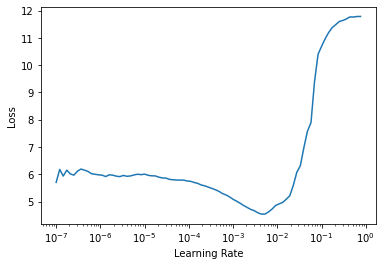

In [22]:
learn.lr_find(suggestions=True)

In [58]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(4,
 tensor(5.1710, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 210, 50264]))

In [59]:
learn.fit_one_cycle(1, lr_max=3e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time
0,2.121053,2.010698,0.169062,0.045667,0.119263,0.682374,0.659969,0.670709,2:36:34


In [60]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,"Jau rudenį vyresnių klasių mokiniams teko pereiti prie nuotolinio ugdymo.Taip mokytis, pasak Lietuvos moksleivių sąjungos prezidentės Saros Aškinytės, sunkiau, o stengtis dėl gero pažymio esą reikia daugiau.„Bet tie, kurie ir anksčiau turėjo gerus pažymius, kurie buvo linkę gerai mokytis, investuoja laiką, stengiasi ir jiems didelės bėdos nėra. Bet kam sunkiau, mokymasis dar labiau pasunkėja ir geresni rezultatai tampa dar sunkiau pasiekiami“, – 15min komentavo ji.Su tuo sutiko ir KTU Inžinerijos licėjaus direktorius Dainius Žvirdauskas.„Labiau motyvuoti kažkokio ypatingo pokyčio mokymuisi neatranda, bet tiems, kur trūko motyvacijos dėl įvairiausių priežasčių, jie dar labiau klimpsta į nenuoseklų mokymąsi, praradimų jie turi žymiai daugiau“, – tikino įstaigos vadovas.Praradimų jau yra ir bus ateityje.Mokymasis technologijų pagalba, jo teigimu, tikrai geriau negu nieko, bet įprastoms pamokoms tai esą niekada neprilygs:„Nereikia turėti iliuzijų, kad čia nebus praradimų. Praradim�","Kai kurios mokyklos jau nuo pat rugsėjo pakaitomis organizavo kontaktinį ir nuotolinį mokymą. Ilgainiui, prastėjant COVID-19 situacijai, liko tik nuotolinis, prie kurio pritaikyti teko net pradinukams. Kaip tai pakeikė mokinių pasiekimus? 15min kalbinti pašnekovai sako, kad tie, kurie stengėsi, stengiasi ir dabar, o nemotyvuotieji priešingai – dar sunkiau susikaupia ir nusiteikia mokymuisi. Taip esą elgiasi ir abiturientai, kuriems sąlygos laikyti egzaminus šįmet bus kiek kitokios.",Lietuvos moksleivių sąjungos prezidentės Saros Aškinytėje vyresnių klasių mokiniams teko pereiti prie nuotolinio ugdymo. Tačiau mokymasis dar labiau pasunkėja ir geresni rezultatai tampa dar sunkiau.
1,"Penkmečio raidos planą aukštosios mokyklos sudarė kovo 12-ąją. Pagal jį, Šiaulių akademijos vykdomos studijos bus grindžiamos „šiaurės Lietuvos regiono poreikiais, Šiaulių miesto ekonominės plėtros ir investicijų pritraukimo strategija“ bei Vyriausybės nutarimu, numatančiu įsteigti pedagogų rengimo centrą.2021-aisiais į Šiaulių akademiją planuojama priimti bent 319 studentų, daugiausia – į profesines pedagogikos studijas.Studijų programų, lyginant su tuo, ką dabar siūlo Šiaulių universitetas (ŠU), bus mažiau.„Noriu pabrėžti, kad programų atsisakome iš esmės ne todėl, kad jungiamės prie VU. Kai kurių programų būtina atsisakyti dėl anksčiau buvusių programų gausybės, neleidusios užtikrinti jų tvarumo (studijuodavo per mažas skaičius studentų panašiose programose, todėl nuspręsta palikti pačias kokybiškiausias ir turinio nedubliuojančias programas) arba kai kurių programų jau kelis metus ar net daugiau nesirinko studentai (pavyzdžiui, istorija, lietuvių kalba, ekologija, kai kurios inžinerinės programos).Netikslinga pri�","Vilniaus universitetas (VU) ir prie jo jungiamas Šiaulių universitetas (ŠU) sutarė dėl Šiaulių akademijos 2020–2024 metų raidos plano. Planuojama, kad šis VU padalinys ateityje vykdys mažiau studijų programų, orientuosis į pedagogines studijas. Raidos plano įgyvendinimui aukštosios mokyklos prašo skirti apie 11 mln. eurų, iš kurių dalis tektų darbuotojų algų suvienodinimui. Jei tam lėšų neatsiras, „akademijai bus taikomos atskiros personalo darbo užmokesčio tvarkos“, kas greičiausiai reiškia, jog Šiaulių akademijos personalas gaus mažesnį darbo užmokestį nei VU.","Šiaulių akademijos vykdomos studijos bus grindžiamos „šiaurės Lietuvos regiono poreikiais“. Penktadienio vakarą pranešė, kad planuojama priimti bent 319 studentų, daugiausia – į profesines pedagogikos studija."


In [61]:
test_article = """Susitelkti teko visiems Praeitos savaitės pabaigoje progimnazijos Tėvų tarybos pirmininkas Arūnas Penkaitis sakė, kad grįžimo į mokyklą laukiama kaip šventės, kaip gimtadienio: „Anksčiau, kai išties turėjome tam tikrą informacijos trūkumą, nuotaikų buvo įvairių. Šiuo metu, gavus atsakymus į visus kilusius klausimus, didžioji dauguma bendruomenės nusiteikusi labai pozityviai.“ Mokyklos direktorius R.Remeika praėjusią savaitę 15min teigė, kad nuotolinis ugdymas nėra toks efektyvus, todėl siekiama kuo greičiau pereiti į kontaktinį mokymą. Pirmadienio rytą jis feisbuke džiaugėsi, kad bendruomenė susitelkė ir atsakingai dirbdama parodė, kiek daug vaikų labui gali padaryti. O ši savaitė taip pat būsianti susitelkimo metas, kai teks griežtai laikytis visų saugumo taisyklių tiek mokykloje, tiek namuose, tiek viešoje erdvėje, nes esą nėra „prabangos“ susirgti ir taip rizikuoti aplinkinių sveikata. Rezultatus vertins po dar vienų testų Anot Vilniaus mero Remigijaus Šimašiaus, prieš grįžtant į klases buvo testuojami ir darbuotojai, ir mokiniai, ir jų šeimų nariai, tad iššūkių netrūko. „Savaitės pabaigoje vėl bus atliekami testai, žiūrėsime, kokie rezultatai. Nes patys suprantame, kad švietimas yra ta sritis, kur labai norisi grįžti į normalias vėžes ir dar geresnes – per pandemiją išmoko naujų dalykų ir mokytojai, ir mokiniai. Kartu suprantame tą riziką – iš Estijos gavome ataskaitą, kad mokyklose didelė rizika, vaikai vieni kitiems perneša. Mūsų tą eksperimentą Lietuvos mastu traktuoju kaip labai svarbų – kaip organizuoti ir kaip paskui viskas vyks“, – kalbėjo R.Šimašius. Mero teigimu, jeigu reikėtų pagal tokią pačią procedūrą atidaryti visas Lietuvos ar Vilniaus mokyklas, tai greičiausia nebūtų įmanoma – resursų niekam ir niekada neužtektų. Todėl reikia apibendrinti išvadas, kaip tai galima padaryti paprasčiau. Apie tai ketinama diskutuoti ir su Vyriausybe. Atsidarytų nors rytoj Paklaustas, kada galėtų visos mokyklos atsidaryti, meras sakė, kad jeigu virusas iš Lietuvos išeitų, tai galima būtų ir rytoj padaryti. „Bet kada jis išeis, kokiu tempu, kokios variacijos, kiti dalykai, negaliu pasakyti. Bet jeigu epidemiologinė situacija leistų, sugrįžti į mokyklas mums nebūtų problemų. Nebent kiltų vienai kitai šeimai, nes ne paslaptis, kad ne vienas moksleivis, kartais ir mokytojai pamokose dalyvauja ne iš Vilniaus, kartais net ir į užsienį išvažiavę“, – sakė R.Šimašius. Jis įsitikinęs, kad tokių ar panašių eksperimentų turėtų būti ir daugiau, tai leistų lengviau grįžti visiems, kai epidemiologinė situacija leis. Vilnius rengė konferenciją su mokytojais, svarstė nuotolinio mokymosi sąlygas ir būdus, tai joje paaiškėjo, kad tiek abiturientai, tiek mokytojai vieningai sako, kad egzaminų vėlinti negalima ir nereikia, yra pasiūlymų, kaip organizuoti juos tinkamai įprastu metu. Buvo teigiamų testų Vilniaus visuomenės sveikatos biuro vadovė Guoda Ropaitė-Beigė teigė, kad viso šio proceso metu mokyklos bendruomenė buvo itin aktyvi: „Ketvirtadienį startavome su pedagogų testavimu kaupinių principu, tai 93 asmenys, sudarėme 39 kaupinius, visi buvo neigiami. Tai tikrai mokytojai saugūs ir sveiki grįžo į šitą įstaigą. O kalbant apie namų ūkius – t. y. vaikus ir jų tėvelius, testavimas vyko penktadienį, šeštadienį ir dar sudarėme galimybę ir sekmadienį testuotis. Buvo per 500 kaupinių, daugiau nei 2 tūkst. asmenų atvyko testuotis į testavimo punktą, keturi kaupiniai buvo teigiami, dabar vykdomi tyrimai PGR tyrimai.“ Šis testavimo būdas skiriasi nuo PGR tuo, kad pastarojo atveju imamas mėginys iš nosiaryklės ir ryklės, o kaupinio – iš nosies landų ir tie ėminiai grupuojami: vienoje virusologinėje terpėje grupuojami ir dedami kelių asmenų ėminius ir jie tiriami. Jeigu gaunamas teigiamas rezultatas, tuomet jau tiems asmenims atliekami PGR testai. Bandomojo projekto laikas – dvi savaitės, pirmoji jau praėjo, antroji yra ši, tad jai baigiantis, penktadienį, planuojamas vizitas į mokyklą, ten bus tiriamos klasės, mėginama pasižiūrėti, kokia situacija savaitę pasimokius kontaktiniu būdu. Jeigu Vyriausybė priims sprendimus, tada bus mokomasi ir kitą savaitę. Šią savaitę Vilnius turėtų gauti 11 tūkst. vakcinų nuo COVID-19, tai džiugina, anot mero, tačiau kiekis vis dar yra per mažas, kad galima būtų sakyti, jog vakcina buvo įveikta pandemija."""

In [62]:
outputs = learn.blurr_generate(test_article, 
                               early_stopping=True, num_beams=5, do_sample=True, 
                               max_length=130, 
                               top_k=50, 
                               top_p=0.95,
                               num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 Antradienio vakarą Vilniaus savivaldybės mokyklą susitelkė nuotolinis nuotaikų buvęs Arūnas Penkaitis sako, kad daugiabučių mokykloje dėl Lietuvos mokytojų ir mokinų sveikatos ir mokymo (LMŽS) gyventojų gimtadienio rytą Lietuvoje

=== Prediction 2 ===
 Trečiadienio vakarą Panevėžyje, Tėvų tarybos pirmininkas Arūnas Penkaitis sako, kad mokyklą nuotaikų buvo įvairių, gavus atsakymus į visus kilusius klausimus, didžioji dauguma bendruomenės nusiteikusi labai pozityviai. Praėjusią savaitę

=== Prediction 3 ===
 Trečiadienio vakarą Panevėžio rajone, Praeitos savaitės pabaigoje, Tėvų tarybos pirmininkas Arūnas Penkaitis sako, kad nuotolinis ugdymas nėra toks efektyvus, kuo greičiau pereiti į kontaktinį mokymą. Praėjusią 15min teigė kalb



In [63]:
learn.blurr_generate(test_article)

[' Antradienio vakarą Panevėžio rajone, Praeitos savaitės pabaigoje progimnazijos „Anksčiau, kai išties turėjome tam tikrą informacijos trūkumą, nuotaikų buvo įvairių. Šiuo metu, gavus atsakymus į visus kilusius klausimus, didžiausia dauguma bendruomenęs nusiteikus']

# SAVE

In [64]:
learn.metrics = None
learn.export(fname='ft_CNN_512_export.pkl')